In [7]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from six.moves import cPickle as pickle
from scipy.misc import imread
import platform


%matplotlib inline

In [8]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

X_train, y_train, X_test, y_test = load_CIFAR10('data/cifar-10-batches-py')

In [9]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform((batch_size, dim), -1, 1, tf.float32)

In [10]:
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)

In [11]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 1600]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """

    with tf.variable_scope("discriminator"):
        W1 = tf.get_variable("W1", shape=[64*6*6, 64*6*6])
        b1 = tf.get_variable("b1", shape=[64*6*6])
        W2 = tf.get_variable("W2", shape=[64*6*6, 1])
        b2 = tf.get_variable("b2", shape=[1])
        
        x = tf.reshape(x, [-1, 32, 32, 3])

        conv1 = tf.layers.conv2d(
            inputs=x, 
            filters=32, 
            kernel_size=[5,5], 
            strides=(1, 1),
            padding='valid',
            activation=leaky_relu
        )
        
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        
        # bn1 = tf.layers.batch_normalization(pool1, training=training)
        conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[3,3],
            strides=(1,1),
            padding='valid',
            activation=leaky_relu
        )
        
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
        # bn2 = tf.layers.batch_normalization(pool1, training=training)
        
        pool2_flat = tf.layers.flatten(pool2)
        
        fc1 = tf.matmul(pool2_flat, W1) + b1
        
        lrelu1 = leaky_relu(fc1)
        
        logits = tf.matmul(lrelu1, W2) + b2
        
        return logits

In [12]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    _, noise_dim = z.shape
    with tf.variable_scope("generator"):
        # TODO: implement architecture

        W1 = tf.get_variable("W1", shape=[noise_dim, 1600])
        b1 = tf.get_variable("b1", shape=[1600])
        
        W2 = tf.get_variable("W2", shape=[1600, 8*8*384])
        b2 = tf.get_variable("b2", shape=[8*8*384])

        fc1 = tf.matmul(z, W1) + b1
        
        relu1 = tf.nn.relu(fc1)
        
        bn1 = tf.layers.batch_normalization(relu1)
        
        fc2 = tf.matmul(bn1, W2) + b2
        
        relu2 = tf.nn.relu(fc2)
        
        bn2 = tf.layers.batch_normalization(relu2)
        
        img_shape = tf.reshape(bn2, [-1, 8, 8, 384])
        
        conv2dt1 = tf.layers.conv2d_transpose(
            inputs=img_shape,
            filters=192,
            kernel_size=[4,4],
            strides=(2, 2),
            padding='same',
            activation=tf.nn.relu,
        )
        
        bn3 = tf.layers.batch_normalization(conv2dt1)
        
        img = tf.layers.conv2d_transpose(
            inputs=bn3,
            filters=3,
            kernel_size=[4,4],
            strides=(2, 2),
            padding='same',
            activation=tf.nn.tanh,
        )

        img = tf.reshape(img, [-1, 3*32*32])
        return img

In [13]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    N = score_real.shape[0]

    D_loss = 0.5 * (tf.reduce_mean(tf.pow(score_real - tf.ones_like(score_real), 2)) + tf.reduce_mean(tf.pow(score_fake, 2)))
    G_loss = 0.5 * tf.reduce_mean(tf.pow(score_fake - tf.ones_like(score_fake), 2))
    
    return D_loss, G_loss

In [14]:
def wgan_loss(logits_real, logits_fake, batch_size, x, G_sample):
    d_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    g_loss = - tf.reduce_mean(logits_fake)
    
    lam = 10
    
    eps = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
    x_h = eps * x + (1 - eps) * G_sample
    
    with tf.variable_scope("", reuse=True) as scope:
        grad_d_x_h = tf.gradients(discriminator(x_h), x_h)
        
    grad_norm = tf.norm(grad_d_x_h[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))
    
    d_loss += lam * grad_pen
    
    return d_loss, g_loss

In [15]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

In [16]:
def get_next_batch(batch_size, previous):
    if previous + batch_size >= X_train.shape[0]:
        previous = 0
    x = X_train[previous:previous+batch_size,:,:,:]
    x = x.reshape([-1, 3072])
    y = y_train[previous:previous+batch_size]
    previous += batch_size
    return x, y, previous

def show_images(images):
    images = np.reshape(images, [images.shape[0], 32, 32, 3])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1] / 3)))

    N = images.shape[0]
    n = N // 5
    fig, axes1 = plt.subplots(n,5,figsize=(12, 12))
    images = deprocess_img(images)
    images = images.astype('uint8')
    for j in range(n):
        for k in range(5):
            if j*5+k < N:
                axes1[j][k].set_axis_off()
                axes1[j][k].imshow(images[j*5+k])
#     images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
#     sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
#     sqrtimg = int(np.ceil(np.sqrt(images.shape[1] / 3)))

#     fig = plt.figure(figsize=(sqrtn, sqrtn))
#     gs = gridspec.GridSpec(sqrtn, sqrtn)
#     gs.update(wspace=0.05, hspace=0.05)

#     for i, img in enumerate(images):
#         ax = plt.subplot(gs[i])
#         plt.axis('off')
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.set_aspect('equal')
#         plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
#     return

def preprocess_img(x):
    return 2 * (x / 255.0) - 1

def deprocess_img(x):
    return ((x + 1) / 2.0 * 256.0)

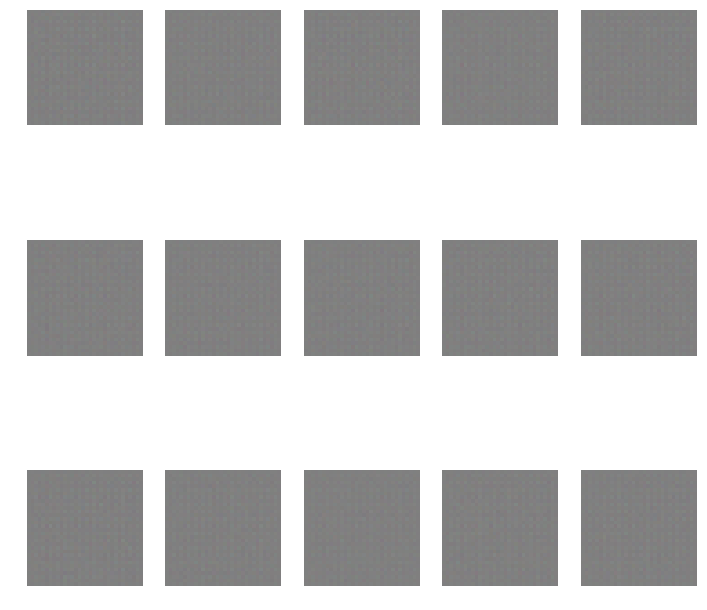


Iter: 0, D: 0.525, G:0.07
Iter: 50, D: 0.1173, G:0.4973
Iter: 100, D: 0.2261, G:0.4325
Iter: 150, D: 0.1728, G:0.2942
Iter: 200, D: 0.2093, G:0.5188


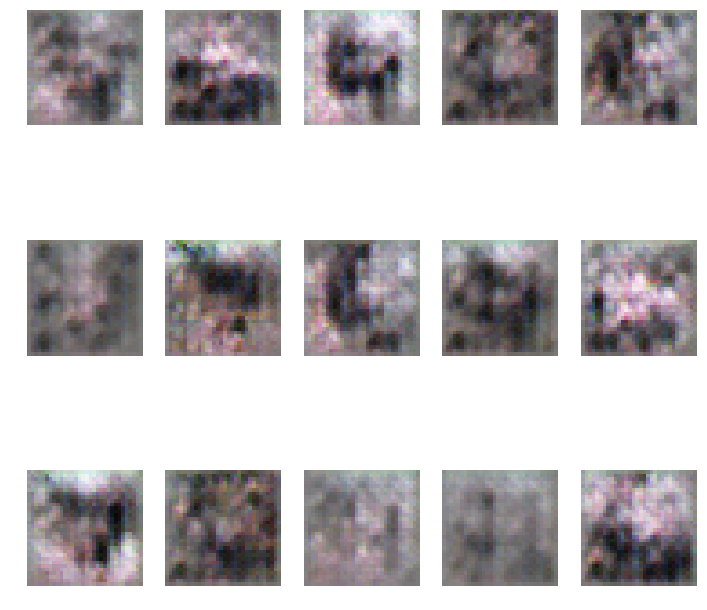


Iter: 250, D: 0.277, G:0.2501
Iter: 300, D: 0.2487, G:0.2041
Iter: 350, D: 0.2429, G:0.2114
Iter: 400, D: 0.2359, G:0.2759
Iter: 450, D: 0.1787, G:0.1765


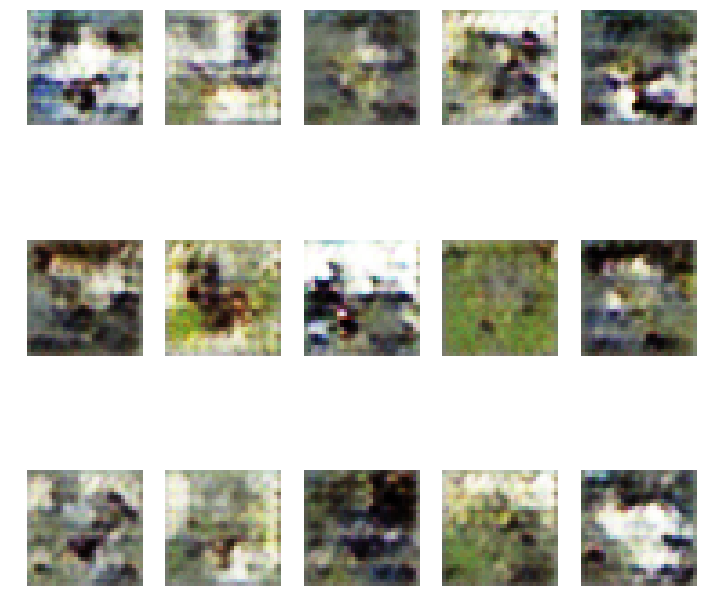


Iter: 500, D: 0.2016, G:0.2557
Iter: 550, D: 0.2466, G:0.2107
Iter: 600, D: 0.2092, G:0.2274
Iter: 650, D: 0.2072, G:0.2879
Iter: 700, D: 0.2244, G:0.1946


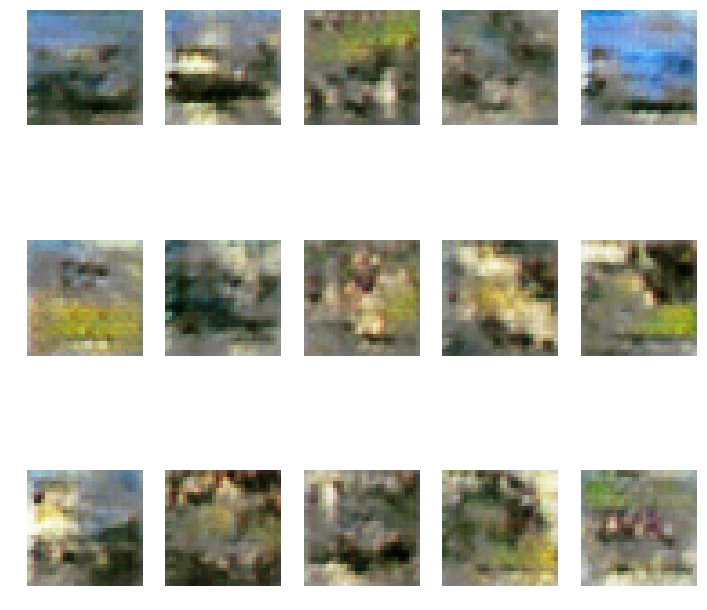


Iter: 750, D: 0.1774, G:0.2195
Iter: 800, D: 0.2032, G:0.2481
Iter: 850, D: 0.2046, G:0.2209
Iter: 900, D: 0.2062, G:0.244
Iter: 950, D: 0.2044, G:0.2069


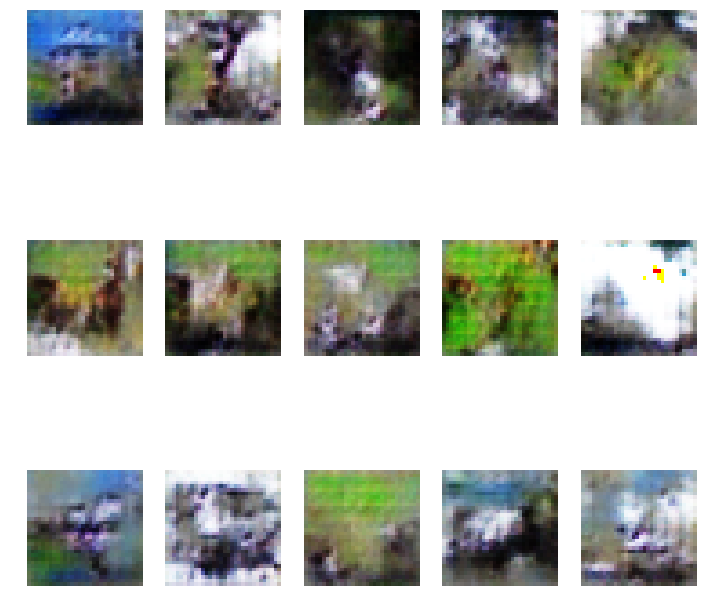


Iter: 1000, D: 0.2025, G:0.2515
Iter: 1050, D: 0.1763, G:0.2312
Iter: 1100, D: 0.2178, G:0.2003
Iter: 1150, D: 0.2455, G:0.2794
Iter: 1200, D: 0.2117, G:0.2184


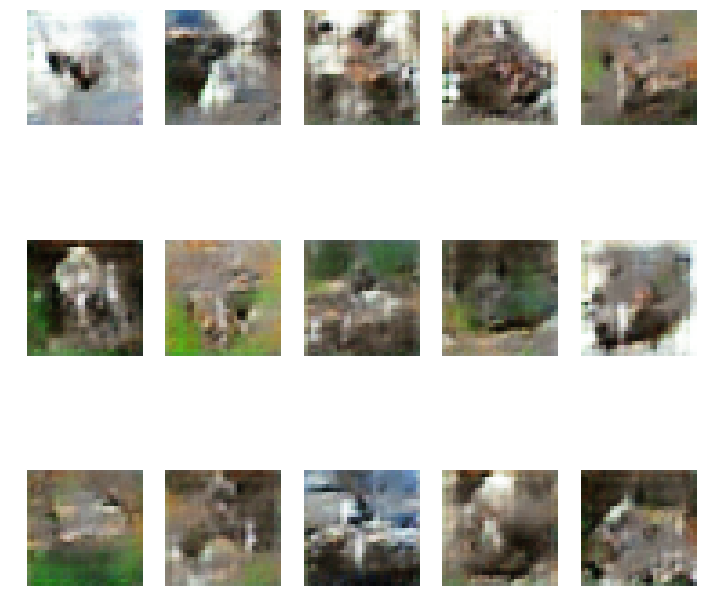


Iter: 1250, D: 0.2178, G:0.2285
Iter: 1300, D: 0.2033, G:0.1913
Iter: 1350, D: 0.1994, G:0.2231
Iter: 1400, D: 0.1734, G:0.2518
Iter: 1450, D: 0.1808, G:0.1957


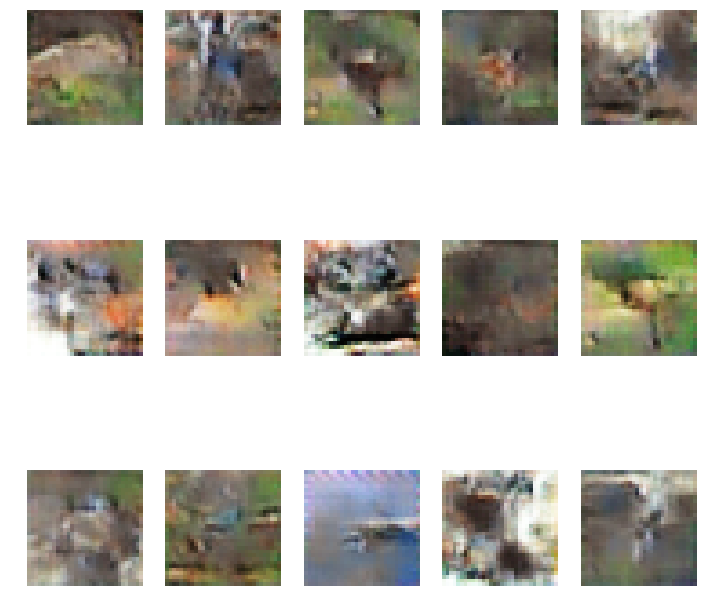


Iter: 1500, D: 0.4429, G:0.4747


In [ ]:
tf.reset_default_graph()

batch_size = 128
noise_dim = 288
num_epoch = 10
max_iter = int(X_train.shape[0]*num_epoch/batch_size)
show_every=250
print_every=50
previous = 0

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 3072])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
# D_loss, G_loss = wgan_loss(logits_real, logits_fake, batch_size, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

with get_session() as sess:
    sess.run(tf.global_variables_initializer())

    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y,previous = get_next_batch(batch_size, previous)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

In [16]:
x, _, _ = get_next_batch(50, 50)

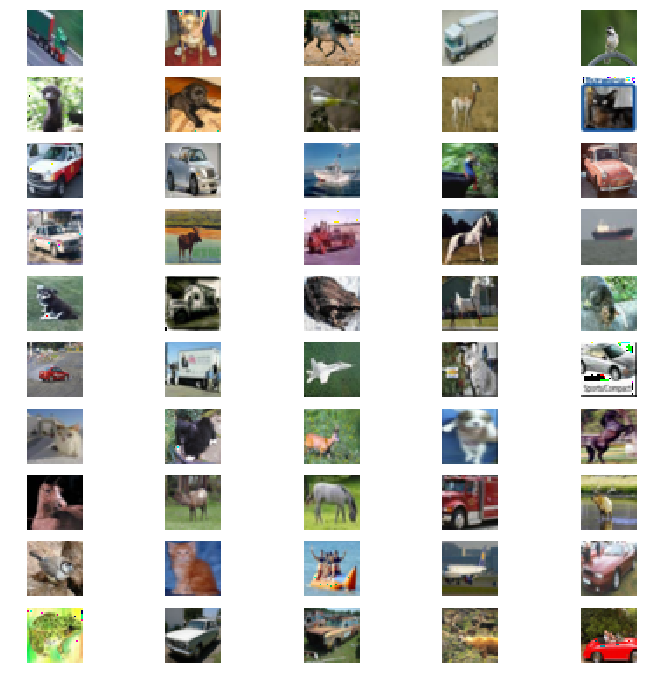

In [19]:
show_images(preprocess_img(x))